# A Closer Look at March of Empires Reviews from the Steam Store 

This project is examining the English language reviews for the game 'March of Empires'. We will examine the reviews for that on the Steam store

Start by gettting the app ID's for the relevant games. 

All games/applications on the Steam store have a unique identifier associated with it, shown in its URL. 

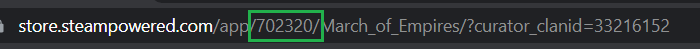

In [2]:
#%reset -f

In [1]:
from bs4 import BeautifulSoup
from itertools import chain
from fake_useragent import UserAgent
import requests
import json

import time
import random
from getpass import getpass


import pandas as pd
import string
import re
import enchant

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Gameloft appids on Steam
gameloft = {
            'Iron Blade: Medieval RPG' : 1087730,
            'Dungeon Hunter 5' : 982510,
            'Dungeon Hunter Champions' : 915580,
            'Modern Combat 5' : 921060,
            'Modern Combat Versus' : 723780,
            'War Planet Online: Global Conquest' : 719640,
            'March of Empires' : 702320,
            'Sniper Fury' : 591740
            }        

Using Steam's API, it is possible to retrieve reviews by players for a particular game.

Review calls take the form:

    'http://store.steampowered.com/appreviews/<APP_ID>?json=1'
    
Reference: https://partner.steamgames.com/doc/store/getreviews

Steam API General Reference: https://partner.steamgames.com/doc/webapi

Below are some helper functions to scrape the actual reviews from users.

The language will be kept as English, since additional translation would be required for non-English reviews. 

In [3]:
def get_reviews_batch(appid, cursor):
    '''
    Get a batch of reviews if a valid http request is made.
    Args: appid --> int, cursor --> str
    Returns: batch --> dict/None
    '''
    parameters = {
            'filter':'recent',
            'language':'english',
            #'day_range':'365',
            'cursor': cursor,
            'review_type':'all',
            'purchase_type':'all',
            'num_per_page':'100',
            }
    reviews_uri = f'http://store.steampowered.com/appreviews/{appid}?json=1'
    
    # header not necessary but help mimic real user
    r = requests.get(reviews_uri, params=parameters, headers={'User-Agent': 'Mozilla/5.0'}) 
    
    batch = None
    if r.ok:
        #print('Request good. JSON instance returned.')
        batch = r.json()
    else:
        print('Invalid or bad Request')
    return batch

def get_all_reviews(appid):
    '''
    Get all reviews for a given app if a valid http request is made.
    Args: appid --> int
    Returns: reviews --> list
    '''
    first_batch = get_reviews_batch(appid,'*') # start cursor at *
    total_num = first_batch['query_summary']['total_reviews'] # total number of reviews
    reviews = first_batch['reviews'] # reviews so far
    cursor = first_batch['cursor'] # new cursor
    print(f'Total of {len(reviews)}/{total_num} retreived.')
    #print(f'Cursor: {cursor}')

    while len(reviews) < total_num:
        # sleep a bit to prevent overwhelming Valve servers
        wait = random.randint(5,10)
        print(f'Getting next batch. Sleeping for {wait} seconds...')
        time.sleep(wait)
        
        next_batch = get_reviews_batch(appid, cursor) # get new batch
        cursor = next_batch['cursor'] # set cursor to latest batch cursor
        reviews.extend(next_batch['reviews']) # attach new batch
        print(f'Total of {len(reviews)}/{total_num} retreived.')
        #print(f'Cursor: {cursor}')

    print('All reviews retrieved.')
    return reviews

Set the desired id for the game 'March of Empires' and retrieve the reviews

In [4]:
id = gameloft['March of Empires'] 
reviews = get_all_reviews(id)

Total of 100/415 retreived.
Getting next batch. Sleeping for 8 seconds...
Total of 200/415 retreived.
Getting next batch. Sleeping for 9 seconds...
Total of 300/415 retreived.
Getting next batch. Sleeping for 5 seconds...
Total of 400/415 retreived.
Getting next batch. Sleeping for 9 seconds...
Total of 415/415 retreived.
All reviews retrieved.


In [5]:
# store to notebook
%store reviews

Stored 'reviews' (list)


In [6]:
# store refresh/retrieve
%store -r reviews

In [7]:
# preview first review
reviews[0]

{'recommendationid': '115660357',
 'author': {'steamid': '76561198294815970',
  'num_games_owned': 94,
  'num_reviews': 2,
  'playtime_forever': 11933,
  'playtime_last_two_weeks': 84,
  'playtime_at_review': 11929,
  'last_played': 1652947449},
 'language': 'english',
 'review': "Keeps getting more and more P2W, if you don't pay into the game, you'll never drop your shield to engage in the pvp aspects.\npve is fun, pvp is little strategy, just stats.",
 'timestamp_created': 1652910670,
 'timestamp_updated': 1652910670,
 'voted_up': False,
 'votes_up': 0,
 'votes_funny': 0,
 'weighted_vote_score': 0,
 'comment_count': 0,
 'steam_purchase': False,
 'received_for_free': False,
 'written_during_early_access': False}

Create a dataframe from the reviews retrieved for further processing.

In [8]:
df = pd.DataFrame(reviews)

In [9]:
# preview dataframe
df[:3]

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,115660357,"{'steamid': '76561198294815970', 'num_games_ow...",english,"Keeps getting more and more P2W, if you don't ...",1652910670,1652910670,False,0,0,0,0,False,False,False
1,115193339,"{'steamid': '76561199074603058', 'num_games_ow...",english,p2p,1652077503,1652077503,False,0,0,0,0,False,True,False
2,114773807,"{'steamid': '76561199195756595', 'num_games_ow...",english,Very good very nice,1651404455,1651404455,True,0,0,0,0,False,True,False


EDA

In [10]:
df.dtypes

recommendationid               object
author                         object
language                       object
review                         object
timestamp_created               int64
timestamp_updated               int64
voted_up                         bool
votes_up                        int64
votes_funny                     int64
weighted_vote_score            object
comment_count                   int64
steam_purchase                   bool
received_for_free                bool
written_during_early_access      bool
dtype: object

The 'author' column contains data about the users making a review. 

It will be put into a seperate DataFrame with the 'steamid' as the primary keys.

In [11]:
df_author = pd.json_normalize(df['author'])
df_author[:5]

,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played
0,76561198294815970,94,2,11933,84,11929,1652947449
1,76561199074603058,2,2,213,213,213,1651903865
2,76561199195756595,2,4,3262,0,337,1651744286
3,76561198795859996,1,1,174343,7381,162465,1652999130
4,76561199054086505,3,1,326,0,320,1651731030


All playtime stats are given in minutes, and last_played is provided in unix/epoch time format.

In [12]:
df_author.describe()

,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played
count,415.000000,415.000000,4.150000e+02,415.000000,415.000000,4.150000e+02
mean,162.595181,66.546988,6.888519e+04,494.219277,30331.843373,1.608830e+09
std,642.882128,469.594194,1.636390e+05,1975.573921,82257.795127,4.443539e+07
min,0.000000,1.000000,5.000000e+00,0.000000,5.000000,1.512990e+09
25%,0.000000,1.000000,1.388000e+03,0.000000,457.000000,1.580541e+09
50%,10.000000,2.000000,1.250500e+04,0.000000,2828.000000,1.623327e+09
75%,73.000000,9.000000,6.949700e+04,0.000000,21635.000000,1.649549e+09
max,6942.000000,6983.000000,1.738170e+06,19825.000000,770436.000000,1.653011e+09


In [13]:
df_author.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   steamid                  415 non-null    object
 1   num_games_owned          415 non-null    int64 
 2   num_reviews              415 non-null    int64 
 3   playtime_forever         415 non-null    int64 
 4   playtime_last_two_weeks  415 non-null    int64 
 5   playtime_at_review       415 non-null    int64 
 6   last_played              415 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 22.8+ KB


Check for any missing/null values

In [14]:
df_author.isnull().sum()

steamid                    0
num_games_owned            0
num_reviews                0
playtime_forever           0
playtime_last_two_weeks    0
playtime_at_review         0
last_played                0
dtype: int64

Plot a correlation matrix.

<AxesSubplot:>

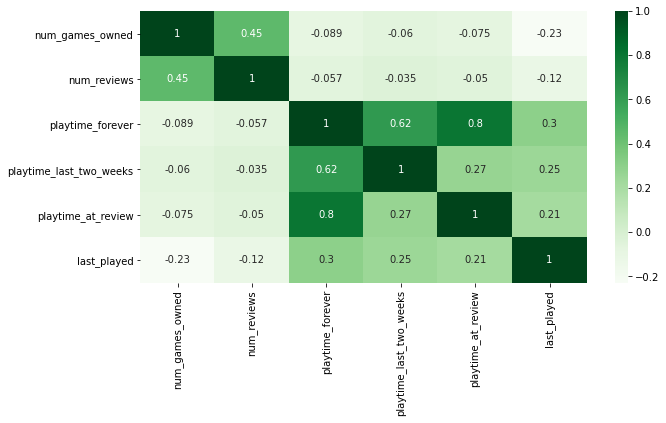

In [15]:
plt.figure(figsize=(10,5))
sns.heatmap(df_author.corr(),cbar=True,annot=True,cmap='Greens')

It can be seen that there is a strong correlation (defined as >0.7) of 0.8 between the reviewer's playtime at the time of review, and their total playtime for the game.

Plot a histogram showing what most of the reviewers playtimes at review are.

<AxesSubplot:xlabel='playtime_at_review', ylabel='Count'>

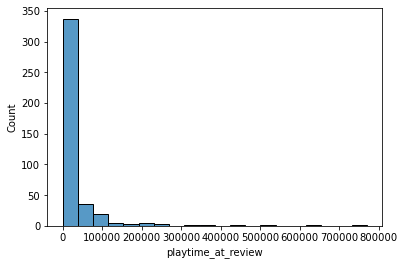

In [16]:
sns.histplot(df_author.playtime_at_review,bins=20)

Plot the relationship between playtime_at_review and playtime_forever

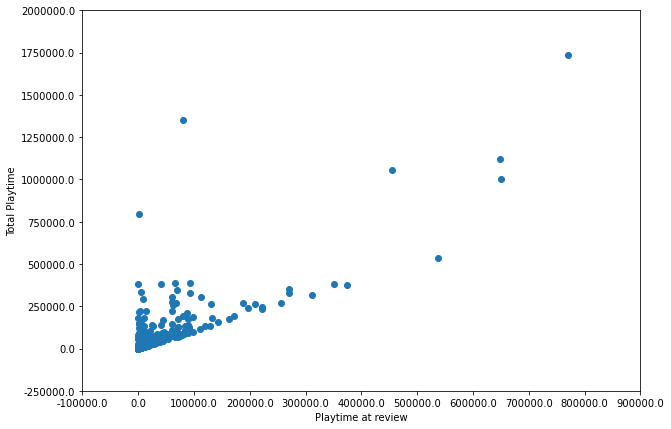

In [17]:
plt.figure(figsize=(10,7))
plt.scatter(x='playtime_at_review',y='playtime_forever',data=df_author)
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0])
plt.xticks(ticks=plt.xticks()[0], labels=plt.xticks()[0])
plt.xlabel('Playtime at review')
plt.ylabel('Total Playtime')

plt.show()

A lot of the playtime at review values fall under 200-300,000  and total playtime under 500,000. Resize the graph to reflect this.

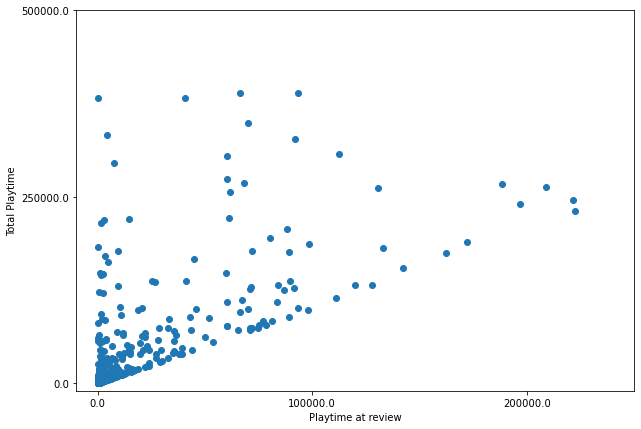

In [22]:
plt.figure(figsize=(10,7))
plt.scatter(x='playtime_at_review',y='playtime_forever',data=df_author)
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0])
plt.xticks(ticks=plt.xticks()[0], labels=plt.xticks()[0])
plt.xlabel('Playtime at review')
plt.ylabel('Total Playtime')

plt.xlim(left=-10000,right=250000)
plt.ylim(bottom=-10000,top=500000)

plt.show()

Add 'steamid' column from df_author back into dataframe containing reviews. 

This will be the foreign key for the df_author dataframe.

In [23]:
df['author_id'] = df_author['steamid']

Reorder the 'author_id' column to immediately after 'author', and drop the 'author' column

In [24]:
list(df.columns)

['recommendationid',
 'author',
 'language',
 'review',
 'timestamp_created',
 'timestamp_updated',
 'voted_up',
 'votes_up',
 'votes_funny',
 'weighted_vote_score',
 'comment_count',
 'steam_purchase',
 'received_for_free',
 'written_during_early_access',
 'author_id']

In [25]:
df = df[
    ['recommendationid',
     'author_id',
     'language',
     'review',
     'timestamp_created',
     'timestamp_updated',
     'voted_up',
     'votes_up',
     'votes_funny',
     'weighted_vote_score',
     'comment_count',
     'steam_purchase',
     'received_for_free',
     'written_during_early_access',
     ]
    ]

In [26]:
df[:5]

,recommendationid,author_id,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,115660357,76561198294815970,english,"Keeps getting more and more P2W, if you don't ...",1652910670,1652910670,False,0,0,0,0,False,False,False
1,115193339,76561199074603058,english,p2p,1652077503,1652077503,False,0,0,0,0,False,True,False
2,114773807,76561199195756595,english,Very good very nice,1651404455,1651404455,True,0,0,0,0,False,True,False
3,114569689,76561198795859996,english,"Groundhog day. Perform tasks, try not to let s...",1651077698,1651077698,False,5,1,0.586206912994384766,0,False,False,False
4,114278566,76561199054086505,english,March of Empires is an amazing game,1650635300,1650635300,True,0,1,0,0,False,True,False


Check to see if the dataframe datatypes are ideal.

In [27]:
df.dtypes

recommendationid               object
author_id                      object
language                       object
review                         object
timestamp_created               int64
timestamp_updated               int64
voted_up                         bool
votes_up                        int64
votes_funny                     int64
weighted_vote_score            object
comment_count                   int64
steam_purchase                   bool
received_for_free                bool
written_during_early_access      bool
dtype: object

The 'weighted_vote_score' should be changed to a float.

In [28]:
df['weighted_vote_score'] = df['weighted_vote_score'].astype('float64')

In [29]:
df.dtypes

recommendationid                object
author_id                       object
language                        object
review                          object
timestamp_created                int64
timestamp_updated                int64
voted_up                          bool
votes_up                         int64
votes_funny                      int64
weighted_vote_score            float64
comment_count                    int64
steam_purchase                    bool
received_for_free                 bool
written_during_early_access       bool
dtype: object

At this point it is helpful to output the data to SQL.

A helper function to create a MySQL connection.

In [30]:
import pymysql
from sqlalchemy import create_engine

Create engine and connect to SQL

In [31]:
user='root'
password=getpass('Enter password: ')
host='localhost'
port='3306'

try:
    engine = create_engine(fr'mysql+pymysql://{user}:{password}@{host}:{port}', echo=False)
    print('SQL connection created.')
except Exception as e:
    print(f'Exception occured: {e}')

Enter password: ········
SQL connection created.


Set up the database for loading

In [32]:
engine.execute('DROP database IF EXISTS march_of_empires')
engine.execute('CREATE DATABASE march_of_empires')
engine.execute('USE march_of_empires')

In [33]:
df_author.to_sql(name='authors', con=engine, if_exists = 'replace', index=False)
df.to_sql(name='reviews', con=engine, if_exists = 'replace', index=False)

Double check in MySQL to see that the tables have sucessfully loaded.

Authors table
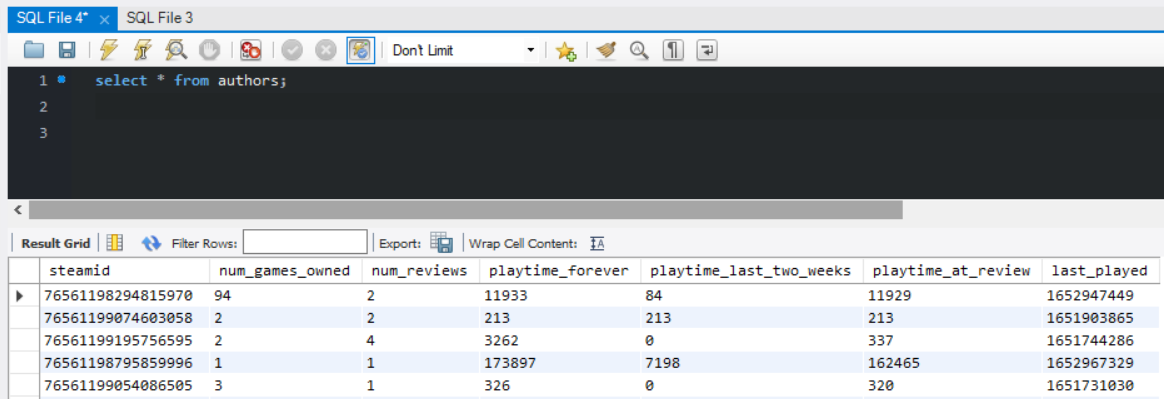

Reviews table
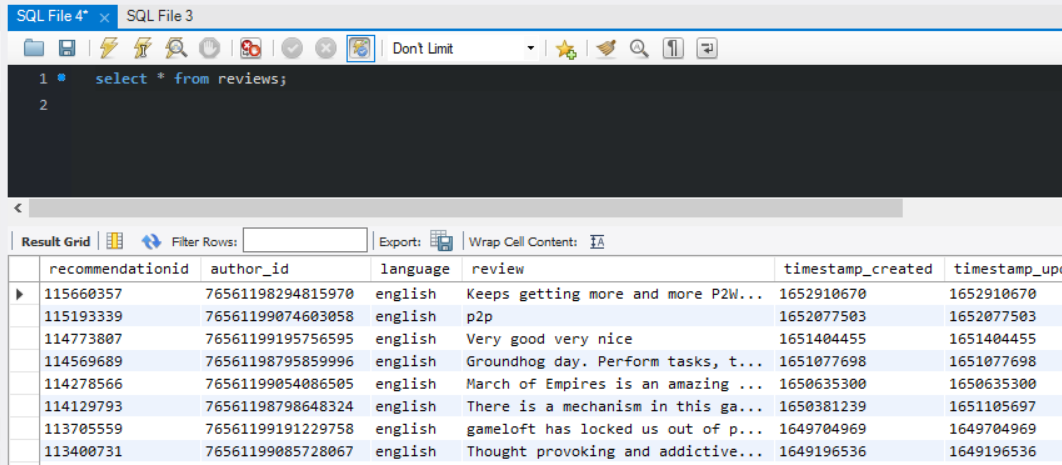

We are interested in what the reviewers have to say about the game. So the column of most interest is 'review'

We will isolate the reviews column as a new Pandas Series.

In [34]:
# interested in the reviews column
reviews_series = df['review']
reviews_series[:5]

0    Keeps getting more and more P2W, if you don't ...
1                                                  p2p
2                                  Very good very nice
3    Groundhog day. Perform tasks, try not to let s...
4                  March of Empires is an amazing game
Name: review, dtype: object

Clean the text for further analysis. Keep only basic punctuation (?,!.;:) and set all to lowercase for easier string matching. Refer to the transformed data as 'reviews_basic' 

In [35]:
#keep letters, numbers, basic punctuation, space
whitelist = set(string.digits+string.ascii_letters+r' .?!;'+'\'')  
reviews_basic = []

# clean the reviews
for review_raw in reviews_series:
    # remove line and tab breaks, make all lowercase
    temp = ''.join(filter(whitelist.__contains__, review_raw.replace('\n',' ').replace('\t',' '))).lower()
    reviews_basic.append(temp)

In [36]:
# compare raw and cleaned
i = 5
print(f'Raw:\n {reviews_series[i]}')
print(f'\nClean:\n {reviews_basic[i]}')

Raw:
 There is a mechanism in this game that has VIP status disabled by default, and you need to use the item that activates it for limited amount of time!

Rework this extra frustrating part of the game, and make VIP active as default forever, (just like the other similar games) and I will give a positive review for this game, when it deserves it.

PS: This also needs an auto-use system for speedups and many more quality of life updates.

Clean:
 there is a mechanism in this game that has vip status disabled by default and you need to use the item that activates it for limited amount of time!  rework this extra frustrating part of the game and make vip active as default forever just like the other similar games and i will give a positive review for this game when it deserves it.  ps this also needs an autouse system for speedups and many more quality of life updates.


In addition, some acronyms such as "P2W" (pay to win) will be of interest. 

So it will be useful to convert all acronyms similar to this to a full phrase.

First, define a dictionary/phrase book of commonly used gaming terms.

Reference: https://ag.hyperxgaming.com/article/8983/gaming-acronyms-every-gamer-should-know

In [37]:
acronyms_dict = {
                'rpg': 'role playing game',
                'rts': 'real time strategy',
                'tbs': 'turn based strategy',
                'fps': 'frames per second',
                'tps': 'third person shooter',
                'br': 'battle royale',
                'moba': 'multiplayer online battle arena',
                'mmo': 'massively multiplayer online',
                'tcg' : 'trading card game',
                'ccg': 'collectible card game',
                'dlc' : 'downloadable content',
                'p2w' : 'pay to win',
                'p2p' : 'pay to play',
                'glhf': 'good luck, have fun',
                'gg' : 'good game',
                'ggwp': 'good game well played',
                'wp': 'well played',
                'afk': 'away from keyboard',
                #'pog': 'pog', # not acronym - shock/surprise
                #'pogchamp' : 'pogchamp', # not acronym - shock/surprise
                #'kappa' : 'kappa', # not acroynym - sarcasm/humor
                'fgc' : 'fighting game community',
                'op' : 'overpowered', # can also mean 'original poster' in a comment/forum thread
                'up' : 'underpowered',
                #'buff' : 'buff', # not acronym - strengthen
                #'nerf' : 'nerf', # not acronym - weaken
                'ui' : 'user interface',
                'hud' : 'heads up display', 
                'fov': 'field of view',
                'los': 'line of sight',
                'aoe': 'area of effect', 
                'dps': 'damage per second',
                'dot': 'damage over time',
                'aggro' : 'aggro', # not acronym - aggrevate/draw attention
                'cs' : 'creep score', # unique to mobas
                'pvp' : 'player vs player',
                'pve' : 'player vs environment',
                'npc' : 'non player character',
                'hp' : 'health', # or health points
                'mp' : 'mana', # or mana points
                'xp' : 'experience', # or experience points
                'mvp' : 'most valuable player'
                }

Helper functions to replace acronyms with words. 

In [38]:
def acronym_to_words(review,acronyms_dict):
    '''
    Convert any acronyms to words given a user review.
    Args: review --> str
    Returns: review_no_acronyms --> str
    '''
    review_word_lst = review.split()
    count = 0
    for word in review_word_lst:
        if word in acronyms_dict:
            # replace with word from acronyms dict
            review_word_lst[review_word_lst.index(word)] = acronyms_dict[word]
            count+=1
    return count,' '.join(review_word_lst)

def replace_acronyms(reviews_list,acronyms_dict):
    '''
    Replace all acronyms with words/phrases
    Args: reviews_list --> list, acronyms_dict --> dict
    Returns: reviews_list --> list
    '''
    total = 0
    reviews_list_no_acronyms = []
    for review in reviews_list:
        result = acronym_to_words(review,acronyms_dict)
        total += result[0]
        reviews_list_no_acronyms.append(result[1])
    print(f'Total of {total} acronyms changed.')
    return reviews_list_no_acronyms

Remove any relevant acronyms, and refer to the transformed data as 'reviews_no_acronyms'

In [39]:
reviews_no_acronyms = replace_acronyms(reviews_basic,acronyms_dict)

Total of 71 acronyms changed.


In [40]:
reviews_no_acronyms[:3]

["keeps getting more and more pay to win if you don't pay into the game you'll never drop your shield to engage in the player vs player aspects. player vs environment is fun player vs player is little strategy just stats.",
 'pay to play',
 'very good very nice']

Break down the reviewers comments into individual sentences. 

In [41]:
from nltk import tokenize

reviews_sentences = []

for review in reviews_no_acronyms:
    reviews_sentences.append(tokenize.sent_tokenize(review))

In [42]:
len(reviews_sentences)

415

In [43]:
# preview
reviews_sentences[0]

["keeps getting more and more pay to win if you don't pay into the game you'll never drop your shield to engage in the player vs player aspects.",
 'player vs environment is fun player vs player is little strategy just stats.']

Join the cleaned reviews back to the Dataframe. Keep the reviews in sentence list format seperate for now, but these can be  added back anytime.

In [44]:
cols = list(df.columns)
cols

['recommendationid',
 'author_id',
 'language',
 'review',
 'timestamp_created',
 'timestamp_updated',
 'voted_up',
 'votes_up',
 'votes_funny',
 'weighted_vote_score',
 'comment_count',
 'steam_purchase',
 'received_for_free',
 'written_during_early_access']

In [45]:
# insert to right after 'review'
df.insert(df.columns.get_loc('timestamp_created'), 'review_clean', reviews_no_acronyms)
df[:5]

,recommendationid,author_id,language,review,review_clean,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,115660357,76561198294815970,english,"Keeps getting more and more P2W, if you don't ...",keeps getting more and more pay to win if you ...,1652910670,1652910670,False,0,0,0.000000,0,False,False,False
1,115193339,76561199074603058,english,p2p,pay to play,1652077503,1652077503,False,0,0,0.000000,0,False,True,False
2,114773807,76561199195756595,english,Very good very nice,very good very nice,1651404455,1651404455,True,0,0,0.000000,0,False,True,False
3,114569689,76561198795859996,english,"Groundhog day. Perform tasks, try not to let s...",groundhog day. perform tasks try not to let sh...,1651077698,1651077698,False,5,1,0.586207,0,False,False,False
4,114278566,76561199054086505,english,March of Empires is an amazing game,march of empires is an amazing game,1650635300,1650635300,True,0,1,0.000000,0,False,True,False


Rexamine the cleaned reviews.

In [46]:
min(df['review_clean'])

''

Some of the reviews, as a result of cleaning, are now empty.

In [47]:
(df['review_clean'].values == '').sum()   

3

In [48]:
df.loc[df['review_clean'] == '']

,recommendationid,author_id,language,review,review_clean,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
45,100321176,76561199195954181,english,>,,1633116123,1633116123,True,0,0,0.000000,0,False,False,False
79,92007030,76561198376966310,english,[,,1621031990,1621031990,True,8,1,0.614035,0,False,False,False
219,66059895,76561199027493424,english,/\n,,1585454115,1585454115,True,0,0,0.000000,0,False,False,False


The reviews shown above are now empty text since they just consisted of nonsensical punctuation.

To cofirm, the 2nd review in the list has 8 upvotes and 1 funny vote. So it is a good idea to double check and see if the review was actually a nonsensical review and not an error in data retrieval.

Going to the original source on the steam page, it is seen that the review really is as shown in the dataframe.

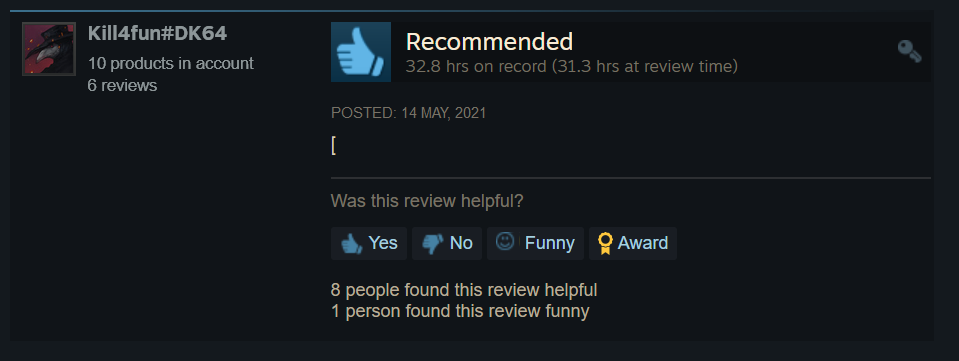

This concludes the project. Some potential next steps are:
    
- Run a spelling/grammar check on the reviews for language processing.
- Generate ngrams to see key words/phrases uses.
- Sentiment analysis to inspect users favored and least favored aspects of the game.
- In SQL, set the primary/foreign keys and restrictions for the data.
- Dashboarding with PowerBI analysis results.